If you want to test the code, you have to insert you api for Google AI toolkit, in the following cell.

In [ ]:
api_key = "GEMINI_API_KEY"

Connect to your Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Change to your project folder mine is:
project_dir = '/content/drive/MyDrive/CPP_Project'
os.chdir(project_dir)
print("Working dir:", os.getcwd())

# Create a directory for CIFAR‑10 images so we can use it for testing
os.makedirs('cifar10_images', exist_ok=True)
print("Created folder:", os.path.join(project_dir, 'cifar10_images'))


Working dir: /content/drive/MyDrive/CPP_Project
Created folder: /content/drive/MyDrive/CPP_Project/cifar10_images


In [ ]:
import os
from torchvision.datasets import CIFAR10

# Download the training split (will store under project_dir/CIFAR10)
dataset = CIFAR10(root='.', train=True, download=True)

# Save first 100 images into cifar10_images/
save_dir = 'cifar10_images'
for idx in range(100):
    img, label = dataset[idx]               # img is a PIL.Image
    filename = f'img_{idx:03d}_label_{label}.png'
    img.save(os.path.join(save_dir, filename))

print(f"Saved {len(os.listdir(save_dir))} images to {save_dir}")


Saved 100 images to cifar10_images


**Test 1:**
Testing how many parellel request the model can hanlde , it fails if we gave it more than 5

In [ ]:
import os, time, base64, requests
from concurrent.futures import ThreadPoolExecutor, as_completed

# API endpoint and headers
GEMINI_URL = (
    "https://generativelanguage.googleapis.com"
    "/v1beta/models/gemini-2.0-flash:generateContent"
    f"?key={api_key}"
)
HEADERS = {"Content-Type": "application/json"}

# Prompt to send with each image
IMG2TXT_PROMPT = (
    "Describe this image in detail. Focus on key visual elements. "
    "However, limit yourself to a single paragraph."
)

# Prepare one test image as base64 payload
img_path = os.path.join("cifar10_images", os.listdir("cifar10_images")[0])
raw      = open(img_path, "rb").read()
b64      = base64.b64encode(raw).decode("utf-8")
payload  = {
    "model": "gemini-2.0-flash",
    "contents": [{
        "parts": [
            {"inlineData": {"mimeType": "image/png", "data": b64}},
            {"text": IMG2TXT_PROMPT}
        ]
    }]
}

def call_once(_):
    """
    Send a single request and measure its latency.
    Returns (status_code, elapsed_time).
    """
    start = time.time()
    r     = requests.post(GEMINI_URL, headers=HEADERS, json=payload)
    return r.status_code, time.time() - start

# Test 1 to 10 concurrent workers
for workers in range(1, 11):
    with ThreadPoolExecutor(workers) as ex:
        # Launch 'workers' parallel calls
        futures = [ex.submit(call_once, i) for i in range(workers)]
        results = [f.result() for f in as_completed(futures)]
    statuses = [s for s, _ in results]
    times    = [t for _, t in results]
    # Print status codes and rounded latencies
    print(
        f"{workers:2d} workers: "
        f"statuses={statuses}, "
        f"times(s)={[round(t, 2) for t in times]}"
    )


 1 workers: statuses=[200], times(s)=[1.04]
 2 workers: statuses=[200, 200], times(s)=[1.01, 1.17]
 3 workers: statuses=[200, 200, 200], times(s)=[0.98, 1.06, 1.12]
 4 workers: statuses=[200, 200, 200, 200], times(s)=[0.89, 0.96, 1.08, 1.22]
 5 workers: statuses=[200, 200, 200, 200, 200], times(s)=[1.05, 1.08, 1.13, 1.15, 1.23]
 6 workers: statuses=[429, 429, 429, 429, 429, 429], times(s)=[0.05, 0.09, 0.1, 0.2, 0.21, 0.21]
 7 workers: statuses=[429, 429, 429, 429, 429, 429, 429], times(s)=[0.13, 0.19, 0.2, 0.19, 0.2, 0.21, 0.21]
 8 workers: statuses=[429, 429, 429, 429, 429, 429, 429, 429], times(s)=[0.06, 0.05, 0.09, 0.19, 0.2, 0.2, 0.2, 0.2]
 9 workers: statuses=[429, 429, 429, 429, 429, 429, 429, 429, 429], times(s)=[0.06, 0.19, 0.19, 0.19, 0.19, 0.19, 0.2, 0.2, 0.21]
10 workers: statuses=[429, 429, 429, 429, 429, 429, 429, 429, 429, 429], times(s)=[0.05, 0.05, 0.05, 0.08, 0.12, 0.2, 0.19, 0.19, 0.2, 0.22]


**test 2.1:** The long vs short prompting

In [ ]:
import time
import requests

# Config
GEMINI_URL = (
    "https://generativelanguage.googleapis.com"
    "/v1beta/models/gemini-2.0-flash:generateContent"
    f"?key={api_key}"                         # your API key defined above
)
HEADERS = {"Content-Type": "application/json"}  # JSON payloads

# Test prompts
short_prompt = "Hello"                          # small input
long_prompt  = "This is a long test sentence. " * 500  # 500× longer

def time_prompt(prompt: str, label: str):
    """
    Send a prompt to Gemini and print its latency.
    """
    payload = {
        "model": "gemini-2.0-flash",
        "contents": [{"parts": [{"text": prompt}]}]  # simple text only
    }
    start = time.time()                         # start timer
    resp  = requests.post(GEMINI_URL, headers=HEADERS, json=payload)
    resp.raise_for_status()
    elapsed = time.time() - start               # compute elapsed time
    print(f"{label} → {len(prompt)} chars: {elapsed:.2f}s")
    return elapsed

# Run tests
for label, p in [("SHORT", short_prompt), ("LONG ", long_prompt)]:
    # do 3 trials and report minimum
    times = [time_prompt(p, label) for _ in range(3)]
    print(f"{label} min latency: {min(times):.2f}s\n")


SHORT → 5 chars: 0.54s
SHORT → 5 chars: 0.59s
SHORT → 5 chars: 0.53s
SHORT min latency: 0.53s

LONG  → 15000 chars: 0.95s
LONG  → 15000 chars: 1.06s
LONG  → 15000 chars: 1.22s
LONG  min latency: 0.95s



**Test 2.2:** Testing the effect of long vs short, prompting and output

Prompt-length test (10 trials):
 Short prompt times: [0.565, 0.55, 0.513, 0.482, 0.522, 0.552, 0.502, 0.491, 0.515, 0.511]
 Long prompt times:  [0.43, 0.55, 0.408, 0.393, 0.561, 0.511, 0.488, 0.38, 0.492, 0.553]
 Averages: Short = 0.521s ± 0.026s, Long = 0.477s ± 0.066s

Output-length test (10 trials):
 Short output times: [0.616, 0.468, 0.415, 0.488, 0.583, 0.557, 0.605, 0.43, 0.566, 0.606]
 Long output times:  [1.011, 1.0, 1.06, 0.895, 0.981, 1.02, 0.806, 1.181, 1.017, 0.881]
 Averages: Short = 0.534s ± 0.072s, Long = 0.985s ± 0.099s



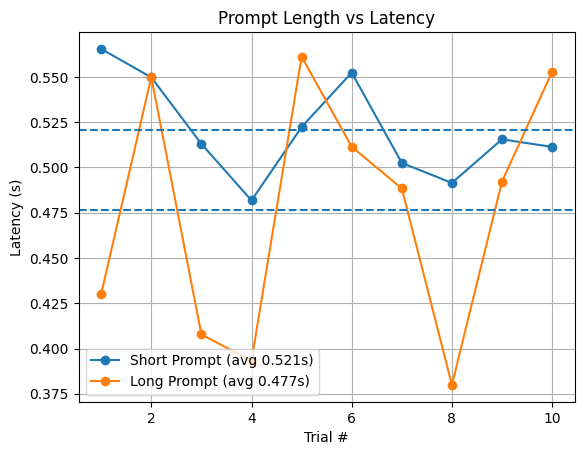

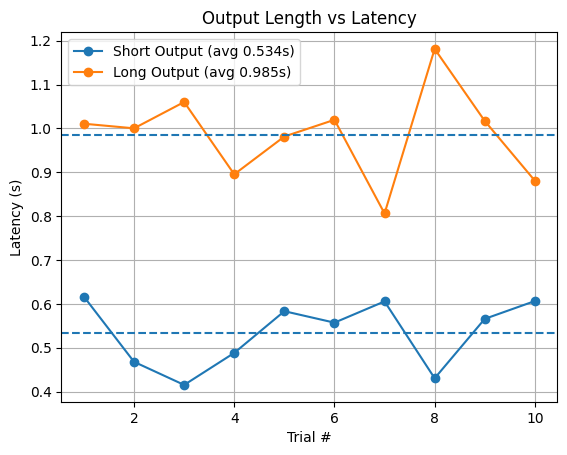

In [ ]:
import time
import requests
import numpy as np
import matplotlib.pyplot as plt

# Config API
GEMINI_URL = (
    "https://generativelanguage.googleapis.com"
    "/v1beta/models/gemini-2.0-flash:generateContent"
    f"?key={api_key}"
)
HEADERS = {"Content-Type": "application/json"}

def time_call(prompt: str, max_toks: int) -> float:
    """
    Send one prompt to Gemini and return the response latency.
    """
    payload = {
        "contents": [
            {"role": "user", "parts": [{"text": prompt}]}
        ],
        # control maximum tokens in response
        "generationConfig": {"maxOutputTokens": max_toks}
    }
    start = time.time()                            # start timer
    r = requests.post(GEMINI_URL, headers=HEADERS, json=payload)
    r.raise_for_status()                           # error if bad status
    return time.time() - start                     # return elapsed time

# Define prompts and output sizes
short_prompt = "Hello"
long_prompt  = "This is a long test sentence. " * 100
fixed_prompt = "Tell me a fun fact about space."
short_output = 20
long_output  = 200

# Warm up API to avoid cold-start overhead
_ = time_call("Warm up", 10)

# Run prompt-length test
times_sp = [time_call(short_prompt, short_output) for _ in range(10)]
times_lp = [time_call(long_prompt,  short_output) for _ in range(10)]

# Run output-length test
times_so = [time_call(fixed_prompt, short_output) for _ in range(10)]
times_lo = [time_call(fixed_prompt, long_output)  for _ in range(10)]

# Compute means and std devs
mean_sp, std_sp = np.mean(times_sp), np.std(times_sp)
mean_lp, std_lp = np.mean(times_lp), np.std(times_lp)
mean_so, std_so = np.mean(times_so), np.std(times_so)
mean_lo, std_lo = np.mean(times_lo), np.std(times_lo)

# Print results with rounded values
print("Prompt-length test (10 trials):")
print(" Short prompt times:", [round(t,3) for t in times_sp])
print(" Long prompt times: ", [round(t,3) for t in times_lp])
print(f" Averages: Short = {mean_sp:.3f}s ± {std_sp:.3f}s, "
      f"Long = {mean_lp:.3f}s ± {std_lp:.3f}s\n")

print("Output-length test (10 trials):")
print(" Short output times:", [round(t,3) for t in times_so])
print(" Long output times: ", [round(t,3) for t in times_lo])
print(f" Averages: Short = {mean_so:.3f}s ± {std_so:.3f}s, "
      f"Long = {mean_lo:.3f}s ± {std_lo:.3f}s\n")

# Plot: Prompt Length vs Latency
x = range(1,11)
plt.figure()
plt.plot(x, times_sp, marker='o', label=f"Short Prompt (avg {mean_sp:.3f}s)")
plt.plot(x, times_lp, marker='o', label=f"Long Prompt  (avg {mean_lp:.3f}s)")
# draw mean lines
plt.axhline(mean_sp, linestyle='--')
plt.axhline(mean_lp, linestyle='--')
plt.xlabel("Trial #")
plt.ylabel("Latency (s)")
plt.title("Prompt Length vs Latency")
plt.legend()
plt.grid(True)

# Plot: Output Length vs Latency
plt.figure()
plt.plot(x, times_so, marker='o', label=f"Short Output (avg {mean_so:.3f}s)")
plt.plot(x, times_lo, marker='o', label=f"Long Output  (avg {mean_lo:.3f}s)")
plt.axhline(mean_so, linestyle='--')
plt.axhline(mean_lo, linestyle='--')
plt.xlabel("Trial #")
plt.ylabel("Latency (s)")
plt.title("Output Length vs Latency")
plt.legend()
plt.grid(True)

plt.show()  # display both figures


**Test 3:** How much time it takes to ge the response for image describting compared to generating quizes

Image Description Times (s): [0.919, 1.119, 0.957, 1.032, 0.943, 1.016, 1.056, 1.28, 1.492, 1.073]
Average Description Time: 1.089s

Quiz Generation Times (s): [1.078, 1.037, 1.043, 0.925, 1.115, 1.099, 1.004, 1.208, 0.894, 1.127]
Average Quiz Time: 1.053s



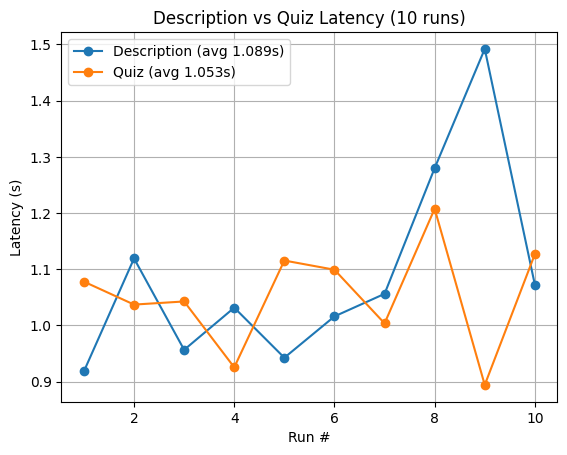

In [ ]:
import time
import os
import base64
import requests
import numpy as np
import matplotlib.pyplot as plt
import random

GEMINI_URL = (
    "https://generativelanguage.googleapis.com"
    "/v1beta/models/gemini-2.0-flash:generateContent"
    f"?key={api_key}"
)
HEADERS = {"Content-Type": "application/json"}

# Prompts
IMG2TXT_PROMPT = """
Describe this image in detail. Focus on key visual elements.
However, limit yourself to a single paragraph.
""".strip()

QUIZ_SYSTEM_PROMPT = """
You are a gentle, patient quiz‑generator whose goal is to help people with dementia reinforce their memory of personal photos.

Given a single image description, create exactly 3 multiple‑choice questions, start with the questions right away without an opening as described. Each question must:

1. Begin with “In your photo ....”
2. Ask about a memorable detail (no trivial or vague attributes).
3. Offer exactly 3 answer choices: one correct and two plausible but incorrect distractors.
4. Avoid impossibilities (e.g., “orange sky” if none was described).
5. Use simple, clear wording appropriate for cognitive training.
6. Separate the questions with ========== and add a new line before each question.
7. Use the format:
   Question 1: <question text>
   A) <option 1>
   B) <option 2>
   C) <option 3>
   Question 2: <question text>
   A) <option 1>
   B) <option 2>
   C) <option 3>
   Question 3: <question text>
   A) <option 1>
   B) <option 2>
   C) <option 3>
""".strip()

# Helper to extract text
def extract_text(cand):
    if "content" in cand:
        c = cand["content"]
        if isinstance(c, str):
            return c.strip()
        if isinstance(c, dict) and "parts" in c:
            return "\n".join(p["text"].strip() for p in c["parts"] if "text" in p)
    if "parts" in cand:
        return "\n".join(p["text"].strip() for p in cand["parts"] if "text" in p)
    return str(cand).strip()

# functions with token limits
def describe_image(path: str) -> str:
    raw = open(path, "rb").read()
    b64 = base64.b64encode(raw).decode("utf-8")
    payload = {
        "model": "gemini-2.0-flash",
        "generationConfig": {"maxOutputTokens": 300},
        "contents": [{
            "parts": [
                {"inlineData": {"mimeType":"image/png","data":b64}},
                {"text": IMG2TXT_PROMPT}
            ]
        }]
    }
    r = requests.post(GEMINI_URL, headers=HEADERS, json=payload)
    r.raise_for_status()
    return extract_text(r.json()["candidates"][0])

def generate_quiz(description: str) -> str:
    payload = {
        "model": "gemini-2.0-flash",
        "generationConfig": {"maxOutputTokens": 200},
        "contents": [{
            "parts": [
                {"text": QUIZ_SYSTEM_PROMPT},
                {"text": description}
            ]
        }]
    }
    r = requests.post(GEMINI_URL, headers=HEADERS, json=payload)
    r.raise_for_status()
    return extract_text(r.json()["candidates"][0])

# Pick one image
img_dir = "cifar10_images"
img_file = random.choice(os.listdir(img_dir))
img_path = os.path.join(img_dir, img_file)

# Warmup
_ = describe_image(img_path)
_ = generate_quiz("Warmup")

# measure 10 runs
times_desc = []
times_quiz = []
for _ in range(10):
    t0 = time.time()
    desc = describe_image(img_path)
    times_desc.append(time.time() - t0)

    t1 = time.time()
    _ = generate_quiz(desc)
    times_quiz.append(time.time() - t1)

# compute stats
avg_desc = np.mean(times_desc)
avg_quiz = np.mean(times_quiz)

# print results
print("Image Description Times (s):", [round(t,3) for t in times_desc])
print(f"Average Description Time: {avg_desc:.3f}s\n")

print("Quiz Generation Times (s):", [round(t,3) for t in times_quiz])
print(f"Average Quiz Time: {avg_quiz:.3f}s\n")

# plotting
x = list(range(1,11))

plt.figure()
plt.plot(x, times_desc, 'o-', label=f"Description (avg {avg_desc:.3f}s)")
plt.plot(x, times_quiz, 'o-', label=f"Quiz (avg {avg_quiz:.3f}s)")
plt.xlabel("Run #")
plt.ylabel("Latency (s)")
plt.title("Description vs Quiz Latency (10 runs)")
plt.legend()
plt.grid(True)
plt.show()


Sequential approach, with measuring the timing and visualizing it

001: describe=1.061s, quiz=1.628s, total=2.689s
→ Attempt 1 failed (503). Retrying in 1.7s…
→ Attempt 1 failed (503). Retrying in 1.4s…
002: describe=3.007s, quiz=2.876s, total=5.883s
003: describe=0.907s, quiz=1.454s, total=2.361s
004: describe=1.213s, quiz=1.223s, total=2.436s
005: describe=1.175s, quiz=1.269s, total=2.444s
006: describe=1.078s, quiz=1.362s, total=2.439s
007: describe=1.175s, quiz=1.367s, total=2.542s
008: describe=0.933s, quiz=1.213s, total=2.146s
009: describe=0.977s, quiz=1.341s, total=2.318s
→ Attempt 1 failed (503). Retrying in 1.2s…
010: describe=2.400s, quiz=1.313s, total=3.714s
011: describe=1.153s, quiz=1.141s, total=2.294s
012: describe=1.022s, quiz=1.075s, total=2.097s
013: describe=1.064s, quiz=1.244s, total=2.308s
014: describe=0.947s, quiz=1.391s, total=2.338s
015: describe=0.880s, quiz=1.470s, total=2.350s
016: describe=1.140s, quiz=1.142s, total=2.282s
017: describe=1.292s, quiz=1.276s, total=2.568s
018: describe=1.082s, quiz=1.218s, total=2.300s
019:

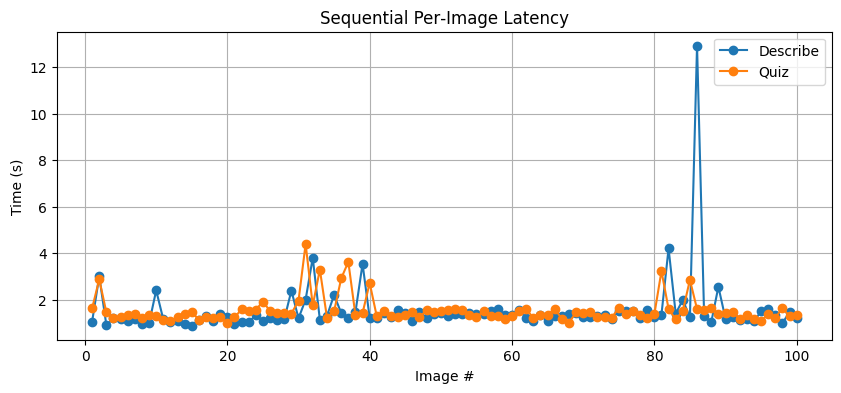

In [ ]:
import os
import time
import random
import base64
import requests
import numpy as np
import matplotlib.pyplot as plt

# API endpoint & headers
GEMINI_URL = (
    "https://generativelanguage.googleapis.com"
    "/v1beta/models/gemini-2.0-flash:generateContent"
    f"?key={api_key}"                        # API key cell above
)
HEADERS = {"Content-Type": "application/json"}

# Prompts
IMG2TXT_PROMPT = """
Describe this image in detail. Focus on key visual elements.
However, limit yourself to a single paragraph.
""".strip()

QUIZ_SYSTEM_PROMPT = """
You are a gentle, patient quiz‑generator whose goal is to help people with dementia reinforce their memory of personal photos.

Given a single image description, create exactly 3 multiple‑choice questions…
""".strip()

# Extract text from various JSON formats
def extract_text(cand: dict) -> str:
    # handle "content" as string or nested parts
    if "content" in cand:
        c = cand["content"]
        if isinstance(c, str):
            return c.strip()
        if isinstance(c, dict) and "parts" in c:
            return "\n".join(p["text"].strip() for p in c["parts"] if "text" in p)
    # fallback to top‑level parts
    if "parts" in cand:
        return "\n".join(p["text"].strip() for p in cand["parts"] if "text" in p)
    return str(cand).strip()

# Retry helper with exponential back‑off
def post_with_backoff(payload, max_retries=5, base_delay=1.0):
    delay = base_delay
    for attempt in range(1, max_retries+1):
        resp = requests.post(GEMINI_URL, headers=HEADERS, json=payload)
        if resp.status_code in (429, 503):
            # rate‑limit or service unavailable: wait and retry
            wait = delay + random.uniform(0, delay)
            print(f"→ Attempt {attempt} failed ({resp.status_code}). Retrying in {wait:.1f}s…")
            time.sleep(wait)
            delay *= 2
            continue
        resp.raise_for_status()
        return resp.json()["candidates"][0]
    # final attempt
    resp.raise_for_status()

# Core functions
def describe_image(path: str) -> str:
    # read image and encode as base64
    raw = open(path, "rb").read()
    b64 = base64.b64encode(raw).decode("utf-8")
    payload = {
        "model":"gemini-2.0-flash",
        "generationConfig":{"maxOutputTokens":300},
        "contents":[{"parts":[
            {"inlineData":{"mimeType":"image/png","data":b64}},
            {"text":IMG2TXT_PROMPT}
        ]}]
    }
    cand = post_with_backoff(payload)  # call with retries
    return extract_text(cand)          # pull out the description

def generate_quiz(desc: str) -> str:
    payload = {
        "model":"gemini-2.0-flash",
        "generationConfig":{"maxOutputTokens":200},
        "contents":[{"parts":[
            {"text":QUIZ_SYSTEM_PROMPT},
            {"text":desc}
        ]}]
    }
    cand = post_with_backoff(payload)  # call with retries
    return extract_text(cand)          # pull out the quiz

# Prepare and warm up
img_dir = "cifar10_images"
files   = sorted(os.listdir(img_dir))[:100]      # first 100 images
paths   = [os.path.join(img_dir, f) for f in files]

_ = describe_image(paths[0])                     # warm up describe
_ = generate_quiz("Warmup")                      # warm up quiz

# Sequential timing loop
desc_times, quiz_times = [], []
start_total = time.time()

for i, p in enumerate(paths, 1):
    t0 = time.time()
    d = describe_image(p)                        # get description
    dt = time.time() - t0
    desc_times.append(dt)

    t1 = time.time()
    _ = generate_quiz(d)                         # generate quiz
    qt = time.time() - t1
    quiz_times.append(qt)

    print(f"{i:03d}: describe={dt:.3f}s, quiz={qt:.3f}s, total={(dt+qt):.3f}s")

total_time = time.time() - start_total
avg_d, std_d = np.mean(desc_times), np.std(desc_times)
avg_q, std_q = np.mean(quiz_times), np.std(quiz_times)

# Summary & plot
print(f"\nAverage describe: {avg_d:.3f}s ± {std_d:.3f}s")
print(f"Average quiz:     {avg_q:.3f}s ± {std_q:.3f}s")
print(f"Total time (100): {total_time:.3f}s")
print(f"Avg per image:    {total_time/len(paths):.3f}s")

x = list(range(1, len(paths)+1))
plt.figure(figsize=(10,4))
plt.plot(x, desc_times, '-o', label="Describe")  # plot describe times
plt.plot(x, quiz_times, '-o', label="Quiz")      # plot quiz times
plt.xlabel("Image #")
plt.ylabel("Time (s)")
plt.title("Sequential Per‑Image Latency")
plt.legend()
plt.grid(True)
plt.show()


Sequential approach, with measuring the timing and visualizing it, with 5 workers

cifar10_images/img_004_label_1.png: describe=1.090s, quiz=1.208s, total=2.298s
cifar10_images/img_002_label_9.png: describe=0.859s, quiz=1.603s, total=2.462s
cifar10_images/img_003_label_4.png: describe=1.132s, quiz=1.427s, total=2.559s
cifar10_images/img_001_label_9.png: describe=1.058s, quiz=1.604s, total=2.663s
cifar10_images/img_000_label_6.png: describe=1.178s, quiz=2.400s, total=3.578s
cifar10_images/img_007_label_7.png: describe=0.866s, quiz=1.140s, total=2.007s
cifar10_images/img_008_label_8.png: describe=1.017s, quiz=1.112s, total=2.129s
cifar10_images/img_006_label_2.png: describe=1.004s, quiz=1.348s, total=2.352s
cifar10_images/img_005_label_1.png: describe=1.087s, quiz=1.452s, total=2.539s
cifar10_images/img_009_label_3.png: describe=0.942s, quiz=1.298s, total=2.240s
cifar10_images/img_012_label_7.png: describe=0.821s, quiz=1.384s, total=2.206s
cifar10_images/img_011_label_7.png: describe=0.970s, quiz=1.345s, total=2.315s
cifar10_images/img_013_label_2.png: describe=0.903s,

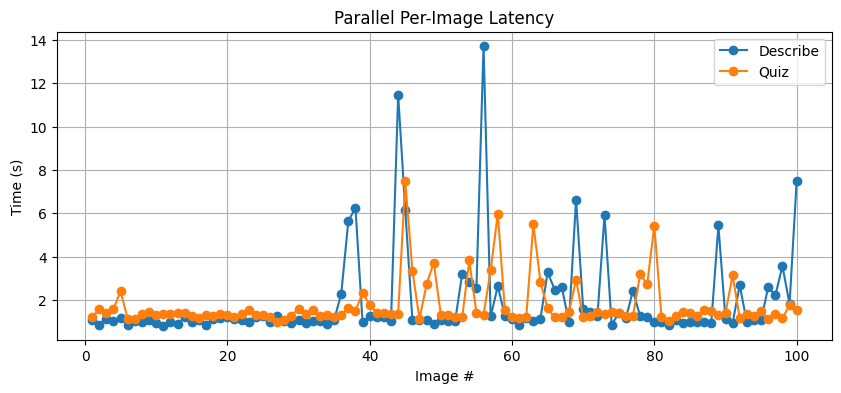

In [ ]:
import os
import time
import random
import base64
import requests
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
from PIL import Image

# API endpoint & headers
GEMINI_URL = (
    "https://generativelanguage.googleapis.com"
    "/v1beta/models/gemini-2.0-flash:generateContent"
    f"?key={api_key}"                        # your API key from above
)
HEADERS = {"Content-Type": "application/json"}  # JSON payloads

# Prompts
IMG2TXT_PROMPT = """
Describe this image in detail. Focus on key visual elements.
However, limit yourself to a single paragraph.
""".strip()

QUIZ_SYSTEM_PROMPT = """
You are a gentle, patient quiz‑generator whose goal is to help people with dementia reinforce their memory of personal photos.

Given a single image description, create exactly 3 multiple‑choice questions…
""".strip()

# Extract text from API candidate
def extract_text(cand: dict) -> str:
    # handle "content" key (string or nested parts)
    if "content" in cand:
        c = cand["content"]
        if isinstance(c, str):
            return c.strip()
        if isinstance(c, dict) and "parts" in c:
            return "\n".join(p["text"].strip() for p in c["parts"] if "text" in p)
    # fallback to top-level parts
    if "parts" in cand:
        return "\n".join(p["text"].strip() for p in cand["parts"] if "text" in p)
    return str(cand).strip()

# Retry helper with exponential back‑off
def post_with_backoff(payload, max_retries=5, base_delay=1.0):
    delay = base_delay
    for attempt in range(1, max_retries + 1):
        resp = requests.post(GEMINI_URL, headers=HEADERS, json=payload)
        if resp.status_code in (429, 503):
            # wait + jitter before retry
            wait = delay + random.uniform(0, delay)
            time.sleep(wait)
            delay *= 2
            continue
        resp.raise_for_status()
        return resp.json()["candidates"][0]
    resp.raise_for_status()  # final attempt

# Core functions
def describe_image(path: str) -> str:
    # read and encode image
    raw = open(path, "rb").read()
    b64 = base64.b64encode(raw).decode("utf-8")
    payload = {
        "model": "gemini-2.0-flash",
        "generationConfig": {"maxOutputTokens": 300},
        "contents": [{
            "parts": [
                {"inlineData": {"mimeType": "image/png", "data": b64}},
                {"text": IMG2TXT_PROMPT}
            ]
        }]
    }
    cand = post_with_backoff(payload)  # API call with retries
    return extract_text(cand)          # get description text

def generate_quiz(desc: str) -> str:
    payload = {
        "model": "gemini-2.0-flash",
        "generationConfig": {"maxOutputTokens": 200},
        "contents": [{
            "parts": [
                {"text": QUIZ_SYSTEM_PROMPT},
                {"text": desc}
            ]
        }]
    }
    cand = post_with_backoff(payload)  # API call with retries
    return extract_text(cand)          # get quiz text

# Prepare images
img_dir = "cifar10_images"
files   = sorted(os.listdir(img_dir))[:100]               # first 100 images
paths   = [os.path.join(img_dir, f) for f in files]

# Warm‑up calls
_ = describe_image(paths[0])      # avoid cold-start penalty
_ = generate_quiz("Warmup")

# Parallel processing with 5 workers
def process_image(path):
    t0   = time.time()
    desc = describe_image(path)   # get description
    dt   = time.time() - t0
    t1   = time.time()
    quiz = generate_quiz(desc)    # get quiz
    qt   = time.time() - t1
    return path, dt, qt

desc_times, quiz_times = [], []
start_overall = time.time()

with ThreadPoolExecutor(max_workers=5) as executor:
    # submit all images to the pool
    futures = {executor.submit(process_image, p): p for p in paths}
    for fut in as_completed(futures):
        path, dt, qt = fut.result()
        desc_times.append(dt)
        quiz_times.append(qt)
        print(f"{path}: describe={dt:.3f}s, quiz={qt:.3f}s, total={(dt+qt):.3f}s")

# Summary & plot
total_time = time.time() - start_overall
avg_desc   = np.mean(desc_times)
avg_quiz   = np.mean(quiz_times)

print(f"\nAverage describe time: {avg_desc:.3f}s")
print(f"Average quiz time:     {avg_quiz:.3f}s")
print(f"Total parallel time:   {total_time:.3f}s")
print(f"Avg time/image:        {total_time/len(paths):.3f}s")

x = list(range(1, len(paths) + 1))
plt.figure(figsize=(10,4))
plt.plot(x, desc_times, '-o', label="Describe")  # describe latencies
plt.plot(x, quiz_times, '-o', label="Quiz")      # quiz latencies
plt.xlabel("Image #")
plt.ylabel("Time (s)")
plt.title("Parallel Per-Image Latency")
plt.legend()
plt.grid(True)
plt.show()


Batch of 20 images with variable workers (1 to 5)

1 workers → total time for 20 images: 77.79s
2 workers → total time for 20 images: 40.42s
3 workers → total time for 20 images: 39.77s
4 workers → total time for 20 images: 25.70s
5 workers → total time for 20 images: 43.97s


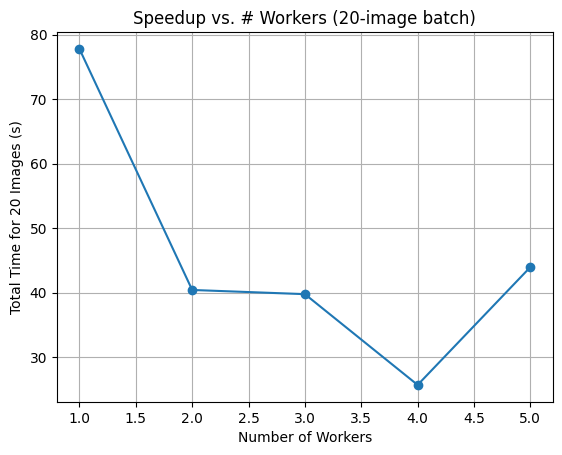

In [ ]:
import os
import time
import random
import base64
import requests
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed

# Configuration (api_key set above)
GEMINI_URL = (
    "https://generativelanguage.googleapis.com"
    "/v1beta/models/gemini-2.0-flash:generateContent"
    f"?key={api_key}"
)
HEADERS = {"Content-Type": "application/json"}

# Prompts for description and quiz
IMG2TXT_PROMPT = """
Describe this image in detail. Focus on key visual elements.
However, limit yourself to a single paragraph.
""".strip()
QUIZ_SYSTEM_PROMPT = """
You are a gentle, patient quiz‑generator whose goal is to help people with dementia reinforce their memory of personal photos.

Given a single image description, create exactly 3 multiple‑choice questions…
""".strip()

def extract_text(cand: dict) -> str:
    # Handle different candidate formats to extract text
    if "content" in cand:
        c = cand["content"]
        if isinstance(c, str):
            return c.strip()
        if isinstance(c, dict) and "parts" in c:
            return "\n".join(p["text"].strip() for p in c["parts"] if "text" in p)
    if "parts" in cand:
        return "\n".join(p["text"].strip() for p in cand["parts"] if "text" in p)
    return str(cand).strip()

def post_with_backoff(payload, max_retries=5, base_delay=1.0):
    # Retry on 429/503 with exponential backoff
    delay = base_delay
    for attempt in range(1, max_retries + 1):
        resp = requests.post(GEMINI_URL, headers=HEADERS, json=payload)
        if resp.status_code in (429, 503):
            wait = delay + random.uniform(0, delay)
            time.sleep(wait)       # wait before retry
            delay *= 2             # double the delay
            continue
        resp.raise_for_status()
        return resp.json()["candidates"][0]
    resp.raise_for_status()

def describe_image(path):
    # Read and encode image, then call API for description
    b64 = base64.b64encode(open(path, "rb").read()).decode()
    payload = {
        "model": "gemini-2.0-flash",
        "generationConfig": {"maxOutputTokens": 300},
        "contents": [{
            "parts": [
                {"inlineData": {"mimeType":"image/png", "data": b64}},
                {"text": IMG2TXT_PROMPT}
            ]
        }]
    }
    return extract_text(post_with_backoff(payload))

def generate_quiz(desc):
    # Send description text to API for quiz generation
    payload = {
        "model": "gemini-2.0-flash",
        "generationConfig": {"maxOutputTokens": 200},
        "contents": [{
            "parts": [
                {"text": QUIZ_SYSTEM_PROMPT},
                {"text": desc}
            ]
        }]
    }
    return extract_text(post_with_backoff(payload))

# Prepare a batch of 20 images
img_dir = "cifar10_images"
files   = sorted(os.listdir(img_dir))[:20]              # take first 20
paths   = [os.path.join(img_dir, f) for f in files]

# Warm up API to avoid cold‑start delay
_ = describe_image(paths[0])
_ = generate_quiz("Warmup")

results = []
# Measure runtime with 1–5 worker threads
for workers in range(1, 6):
    start = time.time()
    with ThreadPoolExecutor(max_workers=workers) as ex:
        futures = [
            ex.submit(lambda p: (describe_image(p), generate_quiz(describe_image(p))), p)
            for p in paths
        ]
        for fut in as_completed(futures):
            fut.result()  # wait for completion
    total = time.time() - start
    results.append((workers, total))
    print(f"{workers} workers → total time for 20 images: {total:.2f}s")

# Plot total time vs. number of workers
workers, times = zip(*results)
plt.figure()
plt.plot(workers, times, marker='o')
plt.xlabel("Number of Workers")
plt.ylabel("Total Time for 20 Images (s)")
plt.title("Speedup vs. # Workers (20-image batch)")
plt.grid(True)
plt.show()
